In [ ]:
!pip install tsflex --no-index --find-links=file:///kaggle/input/time-series-tools
!pip install seglearn --no-index --find-links=file:///kaggle/input/time-series-tools

Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/tsflex-0.3.0-py3-none-any.whl
Looking in links: file:///kaggle/input/time-series-tools
Processing /kaggle/input/time-series-tools/seglearn-1.2.5-py3-none-any.whl


# Data loading and feature extraction

I took help from here https://www.kaggle.com/code/xzj19013742/simple-eda-on-time-for-targets
Try  to develop some features

Data Loading

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob

p = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'

train = glob.glob(p+'train/**/**')
test = glob.glob(p+'test/**/**')
subjects = pd.read_csv(p+'subjects.csv')
tasks = pd.read_csv(p+'tasks.csv')
sub = pd.read_csv(p+'sample_submission.csv')

tdcsfog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')
defog_metadata=pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
tdcsfog_metadata['Module']='tdcsfog'
defog_metadata['Module']='defog'
metadata=pd.concat([tdcsfog_metadata,defog_metadata]

In [ ]:
metadata.head()

,Id,Subject,Visit,Test,Medication,Module
0,003f117e14,13abfd,3,2.0,on,tdcsfog
1,009ee11563,d81e3a,4,2.0,on,tdcsfog
2,011322847a,203e85,2,2.0,on,tdcsfog
3,01d0fe7266,203e85,2,1.0,off,tdcsfog
4,024418ba39,cecfb8,19,3.0,on,tdcsfog


In [ ]:
import pandas as pd
from sklearn import cluster

def cluster_tasks(tasks):
    tasks['Duration'] = tasks['End'] - tasks['Begin']
    tasks_pivot = pd.pivot_table(tasks, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
    tasks_pivot.columns = [c[-1] for c in tasks_pivot.columns]
    tasks_pivot = tasks_pivot.reset_index()
    tasks_pivot['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=13).fit_predict(tasks_pivot[tasks_pivot.columns[1:]])
    return tasks_pivot

def cluster_subjects(subjects):
    subjects = subjects.fillna(0).groupby('Subject').median()
    subjects = subjects.reset_index()
    subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
    subjects = subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})
    return subjects

# Example usage:
tasks_clustered = cluster_tasks(tasks_data)
subjects_clustered = cluster_subjects(subjects_data)

In [ ]:
def create_complex_metadata(metadata, subjects):
    complex_featlist = ['Visit', 'Test', 'Medication', 's_Visit', 's_Age', 's_YearsSinceDx', 's_UPDRSIII_On', 's_UPDRSIII_Off', 's_NFOGQ', 's_kmeans']
    metadata_complex = metadata.merge(subjects, how='left', on='Subject').copy()
    metadata_complex['Medication'] = metadata_complex['Medication'].factorize()[0]
    return metadata_complex[complex_featlist]

metadata_complex = create_complex_metadata(metadata, subjects)

In [ ]:
!pip install tsflex --no-index --find-links=file:///kaggle/input/time-series-tools
!pip install seglearn --no-index --find-links=file:///kaggle/input/time-series-tools

Looking in links: file:///kaggle/input/time-series-tools
Looking in links: file:///kaggle/input/time-series-tools


## Create a tsflex feature collection

In [ ]:
# Import necessary functions from libraries
from seglearn.feature_functions import base_features, emg_features
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper

# Define basic_feats variable to compute basic features
basic_feats = MultipleFeatureDescriptors(seglearn_feature_dict_wrapper(base_features()), ['AccV', 'AccML', 'AccAP'], [5000], [5000])

# Define emg_feats variable to compute emg features
emg_feats = emg_features()
del emg_feats['simple square integral']
emg_feats = MultipleFeatureDescriptors(seglearn_feature_dict_wrapper(emg_feats), ['AccV', 'AccML', 'AccAP'], [5000], [5000])

# Combine the computed features into a FeatureCollection
fc = FeatureCollection([basic_feats, emg_feats])

## Extract the features (with Time_frac feature)

In [ ]:
import pathlib
def reader(file_path):
    try:
        data = pd.read_csv(file_path, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])

        data['Id'] = file_path.split('/')[-1].split('.')[0]
        data['Module'] = pathlib.Path(file_path).parts[-2]

        data['Time_frac']=(data.index/data.index.max()).values

        data = pd.merge(data, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
        data = pd.merge(data, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        features = fc.calculate(data, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        data = data.merge(features, how="left", left_index=True, right_index=True)
        data.fillna(method="ffill", inplace=True)
        return data
    except:
        pass

train = pd.concat([reader(f) for f in tqdm(train)]).fillna(0); print(train.shape)
cols = [c for c in train.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]
pcols = ['StartHesitation', 'Turn' , 'Walking']
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']

  0%|          | 0/970 [00:00<?, ?it/s]

(20588374, 72)


In [ ]:
train=train.reset_index(drop=True)

In [ ]:
train.head()

,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,Module,Time_frac,t_kmeans,...,AccV__minimum__w=5000,AccV__mse__w=5000,AccV__root_mean_square__w=5000,AccV__skew__w=5000,AccV__slope_sign_changes__w=5000,AccV__std__w=5000,AccV__var__w=5000,AccV__waveform_length__w=5000,AccV__willison_amplitude__w=5000,AccV__zero_crossing__w=5000
0,-1.002697,0.022371,0.068304,0,0,0,be9d33541d,defog,0.000000,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0
1,-1.002641,0.019173,0.066162,0,0,0,be9d33541d,defog,0.000008,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0
2,-0.999820,0.019142,0.067536,0,0,0,be9d33541d,defog,0.000017,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0
3,-0.998023,0.018378,0.068409,0,0,0,be9d33541d,defog,0.000025,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0
4,-0.998359,0.016726,0.066448,0,0,0,be9d33541d,defog,0.000034,0.0,...,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0


# EDA: Looking at the distribution of Time for different target variable

1. add time feature: `df['Time_frac']=(df.Time/df.Time.max()).values`(finished in reader() function)
2. visualized the distribution of `Time_frac` for different target variable[`StartHesitation,Turn,Walking`]



<AxesSubplot:>

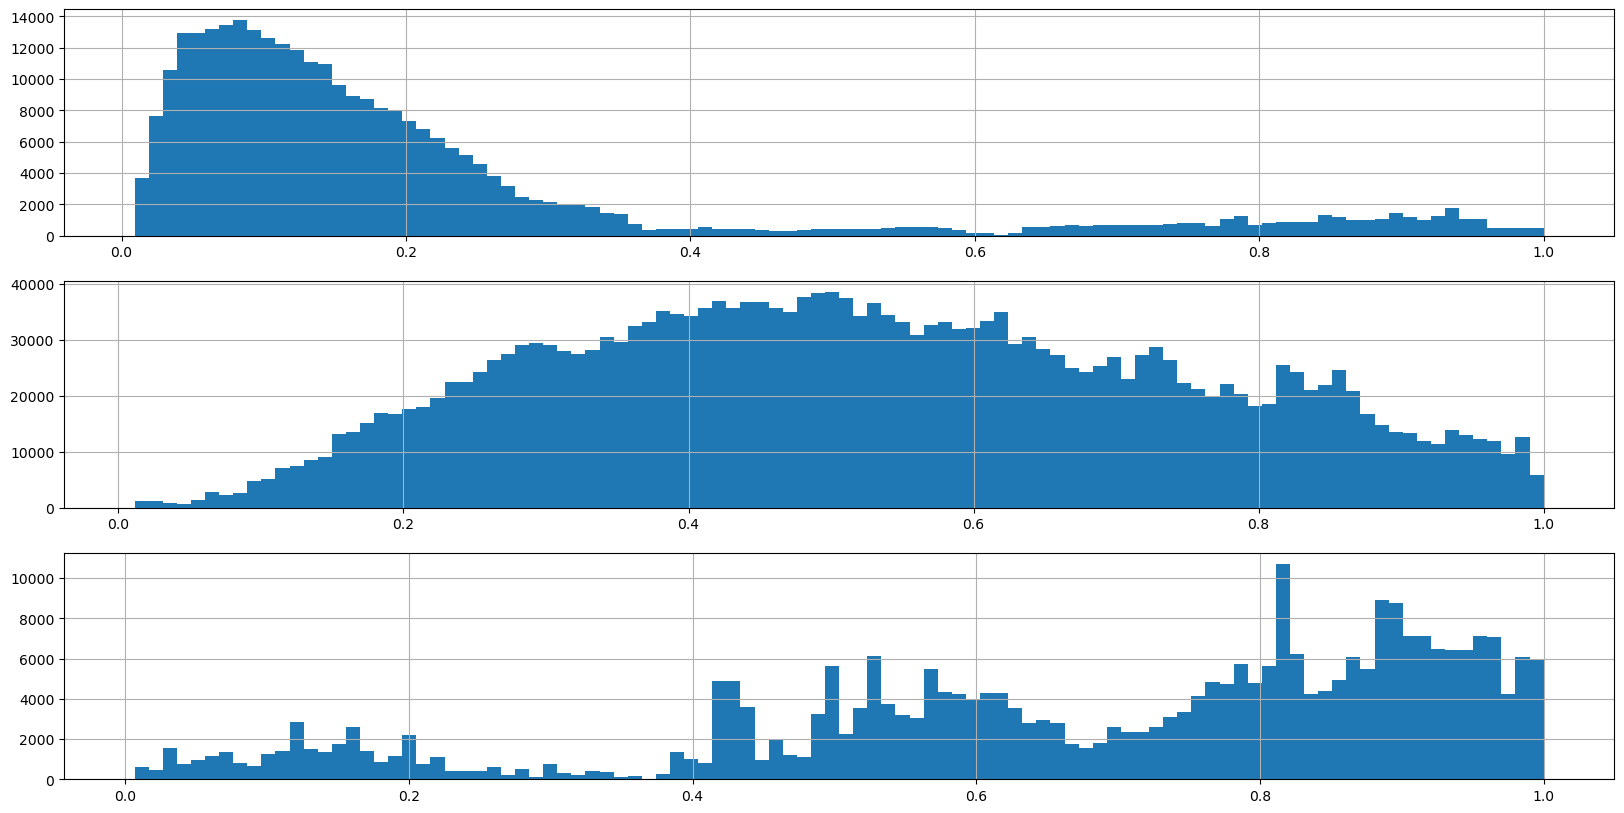

In [ ]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(3,1,figsize=(20,10))
train.loc[train['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100)
train.loc[train['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100)
train.loc[train['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100)

##### The distribution betweeen `the 3 target[StartHesitation,Turn,Walking]` is totally different

##### review the Official definition
> The tDCS FOG (tdcsfog) dataset, comprising data series collected in the lab, as subjects `completed a FOG-provoking protocol`.

> The DeFOG (defog) dataset, comprising data series collected in the subject's home, as subjects `completed a FOG-provoking protocol`

##### EDA Discovery

- StartHesitation frequently occurs in the early stage, and rarely occurs in the late stage
- Turn frequently occurs in the middle stage
- Walking frequently occurs in the late stage

##### Assumption: In a `completed FOG-provoking protocol`, the order in which the event occur tends to follow the order `StartHesitation->Turn->Walking`

##### Application example: Add time fraction feature to model

# Build the model and submit

## Train the model

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer

best_params_ = {'estimator__colsample_bytree': 0.5282057895135501,
 'estimator__learning_rate': 0.22659963168004743,
 'estimator__max_depth': 8,
 'estimator__min_child_weight': 3.1233911067827616,
 'estimator__n_estimators': 291,
 'estimator__subsample': 0.9961057796456088}

In [ ]:
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [ ]:
from sklearn.base import clone

def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True

class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]

        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params)

        return self

In [ ]:
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics
from tqdm import tqdm

def train_and_evaluate(train, cols, pcols, best_params_, N_FOLDS=5):
    kfold = GroupKFold(N_FOLDS)
    group_var = train.Subject
    groups=kfold.split(train, groups=group_var)
    regs=[]
    cvs=[]
    for fold, (train_idx, test_idx) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
        train_idx = pd.Series(train_idx).sample(n=2000000, random_state=2).values
        base_regressor = lgb.LGBMRegressor(**best_params_)
        multioutput_regressor = MultiOutputRegressor(base_regressor)
        x_train, y_train = train.loc[train_idx, cols].to_numpy(), train.loc[train_idx, pcols].to_numpy()
        x_test, y_test = train.loc[test_idx, cols].to_numpy(), train.loc[test_idx, pcols].to_numpy()
        multioutput_regressor.fit(x_train, y_train,
                                  eval_set=(x_test, y_test),
                                  eval_metric=custom_metric,
                                  early_stopping_rounds=25)
        regs.append(multioutput_regressor)
        cv_score = metrics.average_precision_score(y_test, multioutput_regressor.predict(x_test).clip(0.0, 1.0))
        cvs.append(cv_score)
    return cvs


train_and_evaluate(train, test, metadata, tasks, fc, N_FOLDS, best_params_, cols, pcols, scols)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0578913	valid_0's average_precision: 0.127793
[2]	valid_0's l2: 0.0578783	valid_0's average_precision: 0.198022
[3]	valid_0's l2: 0.0579216	valid_0's average_precision: 0.187799
[4]	valid_0's l2: 0.0579757	valid_0's average_precision: 0.156758
[5]	valid_0's l2: 0.0575889	valid_0's average_precision: 0.197729
[6]	valid_0's l2: 0.0574153	valid_0's average_precision: 0.196067
[7]	valid_0's l2: 0.0574742	valid_0's average_precision: 0.193789
[8]	valid_0's l2: 0.057531	valid_0's average_precision: 0.183999
[9]	valid_0's l2: 0.05756	valid_0's average_precision: 0.174796
[10]	valid_0's l2: 0.0575701	valid_0's average_precision: 0.171761
[11]	valid_0's l2: 0.0576327	valid_0's average_precision: 0.154539
[12]	valid_0's l2: 0.0576808	valid_0's average_precision: 0.145211
[13]	valid_0's l2: 0.0576865	valid_0's average_precision: 0.144456
[14]	valid_0's l2: 0.0577137	valid_0's average_precision: 0.141209
[15]	valid_0's l2: 0.057831	valid_0's average_precision: 0.122275
[16]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.190043	valid_0's average_precision: 0.409302
[2]	valid_0's l2: 0.187059	valid_0's average_precision: 0.418666
[3]	valid_0's l2: 0.173495	valid_0's average_precision: 0.495649
[4]	valid_0's l2: 0.167942	valid_0's average_precision: 0.500067
[5]	valid_0's l2: 0.167787	valid_0's average_precision: 0.490573
[6]	valid_0's l2: 0.161475	valid_0's average_precision: 0.524892
[7]	valid_0's l2: 0.158508	valid_0's average_precision: 0.54156
[8]	valid_0's l2: 0.155148	valid_0's average_precision: 0.559211
[9]	valid_0's l2: 0.154755	valid_0's average_precision: 0.557064
[10]	valid_0's l2: 0.155763	valid_0's average_precision: 0.549172
[11]	valid_0's l2: 0.153849	valid_0's average_precision: 0.558765
[12]	valid_0's l2: 0.151278	valid_0's average_precision: 0.562035
[13]	valid_0's l2: 0.147541	valid_0's average_precision: 0.57817
[14]	valid_0's l2: 0.141178	valid_0's average_precision: 0.603626
[15]	valid_0's l2: 0.135313	valid_0's average_precision: 0.639848
[16]	valid_0's l2: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0357961	valid_0's average_precision: 0.0736189
[2]	valid_0's l2: 0.0356519	valid_0's average_precision: 0.102194
[3]	valid_0's l2: 0.0356923	valid_0's average_precision: 0.107075
[4]	valid_0's l2: 0.035485	valid_0's average_precision: 0.0986197
[5]	valid_0's l2: 0.0355067	valid_0's average_precision: 0.0904871
[6]	valid_0's l2: 0.0356457	valid_0's average_precision: 0.0872091
[7]	valid_0's l2: 0.0359835	valid_0's average_precision: 0.0820111
[8]	valid_0's l2: 0.0359977	valid_0's average_precision: 0.0800289
[9]	valid_0's l2: 0.0360738	valid_0's average_precision: 0.0743003
[10]	valid_0's l2: 0.035957	valid_0's average_precision: 0.0791595
[11]	valid_0's l2: 0.0362938	valid_0's average_precision: 0.0790644
[12]	valid_0's l2: 0.0362941	valid_0's average_precision: 0.0790257
[13]	valid_0's l2: 0.0363357	valid_0's average_precision: 0.0771438
[14]	valid_0's l2: 0.0364101	valid_0's average_precision: 0.0764605
[15]	valid_0's l2: 0.036592	valid_0's average_precision: 0.07

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00859369	valid_0's average_precision: 0.0127791
[2]	valid_0's l2: 0.00861361	valid_0's average_precision: 0.013336
[3]	valid_0's l2: 0.00855131	valid_0's average_precision: 0.0693991
[4]	valid_0's l2: 0.00837132	valid_0's average_precision: 0.0937258
[5]	valid_0's l2: 0.00838172	valid_0's average_precision: 0.0867979
[6]	valid_0's l2: 0.0087792	valid_0's average_precision: 0.0639954
[7]	valid_0's l2: 0.00884372	valid_0's average_precision: 0.0616063
[8]	valid_0's l2: 0.00899839	valid_0's average_precision: 0.0604243
[9]	valid_0's l2: 0.00894661	valid_0's average_precision: 0.076044
[10]	valid_0's l2: 0.00899954	valid_0's average_precision: 0.0687271
[11]	valid_0's l2: 0.00901247	valid_0's average_precision: 0.066661
[12]	valid_0's l2: 0.00901612	valid_0's average_precision: 0.0665362
[13]	valid_0's l2: 0.00900289	valid_0's average_precision: 0.0742721
[14]	valid_0's l2: 0.00902577	valid_0's average_precision: 0.0816045
[15]	valid_0's l2: 0.00900292	valid_0's average

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.10312	valid_0's average_precision: 0.315882
[2]	valid_0's l2: 0.0943167	valid_0's average_precision: 0.430897
[3]	valid_0's l2: 0.09415	valid_0's average_precision: 0.424757
[4]	valid_0's l2: 0.091241	valid_0's average_precision: 0.447422
[5]	valid_0's l2: 0.0899961	valid_0's average_precision: 0.425344
[6]	valid_0's l2: 0.0885196	valid_0's average_precision: 0.430894
[7]	valid_0's l2: 0.0869334	valid_0's average_precision: 0.435586
[8]	valid_0's l2: 0.0870601	valid_0's average_precision: 0.424411
[9]	valid_0's l2: 0.0853098	valid_0's average_precision: 0.442512
[10]	valid_0's l2: 0.0846287	valid_0's average_precision: 0.451606
[11]	valid_0's l2: 0.0845475	valid_0's average_precision: 0.449967
[12]	valid_0's l2: 0.0841426	valid_0's average_precision: 0.454131
[13]	valid_0's l2: 0.082706	valid_0's average_precision: 0.47229
[14]	valid_0's l2: 0.0831025	valid_0's average_precision: 0.465068
[15]	valid_0's l2: 0.0827101	valid_0's average_precision: 0.470095
[16]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0045607	valid_0's average_precision: 0.00435174
[2]	valid_0's l2: 0.00464928	valid_0's average_precision: 0.00803128
[3]	valid_0's l2: 0.00473721	valid_0's average_precision: 0.00701041
[4]	valid_0's l2: 0.0047209	valid_0's average_precision: 0.0107359
[5]	valid_0's l2: 0.00473053	valid_0's average_precision: 0.0108073
[6]	valid_0's l2: 0.00475515	valid_0's average_precision: 0.011071
[7]	valid_0's l2: 0.00482182	valid_0's average_precision: 0.0100019
[8]	valid_0's l2: 0.00483485	valid_0's average_precision: 0.0104586
[9]	valid_0's l2: 0.0048682	valid_0's average_precision: 0.0100575
[10]	valid_0's l2: 0.00488404	valid_0's average_precision: 0.00964209
[11]	valid_0's l2: 0.00492262	valid_0's average_precision: 0.00958716
[12]	valid_0's l2: 0.00496017	valid_0's average_precision: 0.00925865
[13]	valid_0's l2: 0.00503431	valid_0's average_precision: 0.0100685
[14]	valid_0's l2: 0.00507618	valid_0's average_precision: 0.00963351
[15]	valid_0's l2: 0.00508245	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00125187	valid_0's average_precision: 0.000852595
[2]	valid_0's l2: 0.00122417	valid_0's average_precision: 0.00760014
[3]	valid_0's l2: 0.0013064	valid_0's average_precision: 0.00479268
[4]	valid_0's l2: 0.00144027	valid_0's average_precision: 0.00429331
[5]	valid_0's l2: 0.00139231	valid_0's average_precision: 0.00961691
[6]	valid_0's l2: 0.00144247	valid_0's average_precision: 0.0124427
[7]	valid_0's l2: 0.00145435	valid_0's average_precision: 0.0118658
[8]	valid_0's l2: 0.00152303	valid_0's average_precision: 0.0113202
[9]	valid_0's l2: 0.00157188	valid_0's average_precision: 0.0114948
[10]	valid_0's l2: 0.00158552	valid_0's average_precision: 0.0113789
[11]	valid_0's l2: 0.00156534	valid_0's average_precision: 0.0156995
[12]	valid_0's l2: 0.00156085	valid_0's average_precision: 0.0173034
[13]	valid_0's l2: 0.00159028	valid_0's average_precision: 0.0170594
[14]	valid_0's l2: 0.00165266	valid_0's average_precision: 0.0174093
[15]	valid_0's l2: 0.00167864	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0606403	valid_0's average_precision: 0.128216
[2]	valid_0's l2: 0.0593771	valid_0's average_precision: 0.1386
[3]	valid_0's l2: 0.059146	valid_0's average_precision: 0.134208
[4]	valid_0's l2: 0.0595012	valid_0's average_precision: 0.128994
[5]	valid_0's l2: 0.0589173	valid_0's average_precision: 0.148263
[6]	valid_0's l2: 0.0585195	valid_0's average_precision: 0.159584
[7]	valid_0's l2: 0.0582912	valid_0's average_precision: 0.163117
[8]	valid_0's l2: 0.057981	valid_0's average_precision: 0.169384
[9]	valid_0's l2: 0.0576062	valid_0's average_precision: 0.177133
[10]	valid_0's l2: 0.0579876	valid_0's average_precision: 0.17382
[11]	valid_0's l2: 0.0579178	valid_0's average_precision: 0.176081
[12]	valid_0's l2: 0.0579434	valid_0's average_precision: 0.177352
[13]	valid_0's l2: 0.0577931	valid_0's average_precision: 0.181561
[14]	valid_0's l2: 0.057776	valid_0's average_precision: 0.184058
[15]	valid_0's l2: 0.0578996	valid_0's average_precision: 0.183712
[16]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00186685	valid_0's average_precision: 0.00179524
[2]	valid_0's l2: 0.00191979	valid_0's average_precision: 0.00213067
[3]	valid_0's l2: 0.00193105	valid_0's average_precision: 0.00196683
[4]	valid_0's l2: 0.00191757	valid_0's average_precision: 0.0044933
[5]	valid_0's l2: 0.00191371	valid_0's average_precision: 0.00520651
[6]	valid_0's l2: 0.00194498	valid_0's average_precision: 0.00445344
[7]	valid_0's l2: 0.00195076	valid_0's average_precision: 0.00420416
[8]	valid_0's l2: 0.00196008	valid_0's average_precision: 0.00498241
[9]	valid_0's l2: 0.00195086	valid_0's average_precision: 0.00549779
[10]	valid_0's l2: 0.00198548	valid_0's average_precision: 0.00511221
[11]	valid_0's l2: 0.00198449	valid_0's average_precision: 0.00502178
[12]	valid_0's l2: 0.00200863	valid_0's average_precision: 0.00527265
[13]	valid_0's l2: 0.00201194	valid_0's average_precision: 0.00512148
[14]	valid_0's l2: 0.00208032	valid_0's average_precision: 0.00443842
[15]	valid_0's l2: 0.00209517	

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00595123	valid_0's average_precision: 0.00666547
[2]	valid_0's l2: 0.00593268	valid_0's average_precision: 0.0103096
[3]	valid_0's l2: 0.00604771	valid_0's average_precision: 0.0089589
[4]	valid_0's l2: 0.00607448	valid_0's average_precision: 0.00944127
[5]	valid_0's l2: 0.00613834	valid_0's average_precision: 0.010059
[6]	valid_0's l2: 0.00618078	valid_0's average_precision: 0.00842617
[7]	valid_0's l2: 0.00615531	valid_0's average_precision: 0.0288988
[8]	valid_0's l2: 0.00621712	valid_0's average_precision: 0.0271284
[9]	valid_0's l2: 0.00625728	valid_0's average_precision: 0.0255575
[10]	valid_0's l2: 0.00626175	valid_0's average_precision: 0.0259201
[11]	valid_0's l2: 0.00630595	valid_0's average_precision: 0.0250381
[12]	valid_0's l2: 0.00631054	valid_0's average_precision: 0.0259512
[13]	valid_0's l2: 0.00633045	valid_0's average_precision: 0.0250572
[14]	valid_0's l2: 0.00632966	valid_0's average_precision: 0.0255508
[15]	valid_0's l2: 0.00633086	valid_0's a

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0736212	valid_0's average_precision: 0.346709
[2]	valid_0's l2: 0.0696099	valid_0's average_precision: 0.363309
[3]	valid_0's l2: 0.0686395	valid_0's average_precision: 0.352254
[4]	valid_0's l2: 0.0664482	valid_0's average_precision: 0.384912
[5]	valid_0's l2: 0.0660143	valid_0's average_precision: 0.376377
[6]	valid_0's l2: 0.0654939	valid_0's average_precision: 0.37837
[7]	valid_0's l2: 0.0643628	valid_0's average_precision: 0.403049
[8]	valid_0's l2: 0.063979	valid_0's average_precision: 0.401369
[9]	valid_0's l2: 0.0635944	valid_0's average_precision: 0.410878
[10]	valid_0's l2: 0.0633216	valid_0's average_precision: 0.423511
[11]	valid_0's l2: 0.0636045	valid_0's average_precision: 0.416684
[12]	valid_0's l2: 0.0637078	valid_0's average_precision: 0.418914
[13]	valid_0's l2: 0.0637822	valid_0's average_precision: 0.417953
[14]	valid_0's l2: 0.0641705	valid_0's average_precision: 0.406663
[15]	valid_0's l2: 0.0640478	valid_0's average_precision: 0.415984
[16]	v

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0258285	valid_0's average_precision: 0.0282626
[2]	valid_0's l2: 0.0258768	valid_0's average_precision: 0.0268687
[3]	valid_0's l2: 0.0260275	valid_0's average_precision: 0.030038
[4]	valid_0's l2: 0.026069	valid_0's average_precision: 0.0307277
[5]	valid_0's l2: 0.0261257	valid_0's average_precision: 0.0315371
[6]	valid_0's l2: 0.0261672	valid_0's average_precision: 0.0340027
[7]	valid_0's l2: 0.0261778	valid_0's average_precision: 0.0326199
[8]	valid_0's l2: 0.0261859	valid_0's average_precision: 0.0364253
[9]	valid_0's l2: 0.0261374	valid_0's average_precision: 0.0372395
[10]	valid_0's l2: 0.026152	valid_0's average_precision: 0.0356289
[11]	valid_0's l2: 0.0261649	valid_0's average_precision: 0.0376296
[12]	valid_0's l2: 0.0261722	valid_0's average_precision: 0.0374357
[13]	valid_0's l2: 0.0261779	valid_0's average_precision: 0.0378751
[14]	valid_0's l2: 0.0261845	valid_0's average_precision: 0.0372776
[15]	valid_0's l2: 0.0261692	valid_0's average_precision: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.000674703	valid_0's average_precision: 0.000449729
[2]	valid_0's l2: 0.000660686	valid_0's average_precision: 0.00247584
[3]	valid_0's l2: 0.000759889	valid_0's average_precision: 0.00170041
[4]	valid_0's l2: 0.00086684	valid_0's average_precision: 0.00179165
[5]	valid_0's l2: 0.000956294	valid_0's average_precision: 0.00171133
[6]	valid_0's l2: 0.000988506	valid_0's average_precision: 0.00148669
[7]	valid_0's l2: 0.00104514	valid_0's average_precision: 0.00280146
[8]	valid_0's l2: 0.0011483	valid_0's average_precision: 0.00312858
[9]	valid_0's l2: 0.00114481	valid_0's average_precision: 0.00325083
[10]	valid_0's l2: 0.00113933	valid_0's average_precision: 0.00325317
[11]	valid_0's l2: 0.00117708	valid_0's average_precision: 0.00307577
[12]	valid_0's l2: 0.00117389	valid_0's average_precision: 0.00338806
[13]	valid_0's l2: 0.00117714	valid_0's average_precision: 0.00340618
[14]	valid_0's l2: 0.00119458	valid_0's average_precision: 0.00327532
[15]	valid_0's l2: 0.001

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0482938	valid_0's average_precision: 0.1128
[2]	valid_0's l2: 0.0462838	valid_0's average_precision: 0.138812
[3]	valid_0's l2: 0.0448674	valid_0's average_precision: 0.159653
[4]	valid_0's l2: 0.0447092	valid_0's average_precision: 0.14714
[5]	valid_0's l2: 0.044362	valid_0's average_precision: 0.157904
[6]	valid_0's l2: 0.0439967	valid_0's average_precision: 0.160526
[7]	valid_0's l2: 0.0436751	valid_0's average_precision: 0.174608
[8]	valid_0's l2: 0.043162	valid_0's average_precision: 0.191334
[9]	valid_0's l2: 0.0427469	valid_0's average_precision: 0.208578
[10]	valid_0's l2: 0.0429486	valid_0's average_precision: 0.202725
[11]	valid_0's l2: 0.0429609	valid_0's average_precision: 0.205033
[12]	valid_0's l2: 0.0428489	valid_0's average_precision: 0.211956
[13]	valid_0's l2: 0.042627	valid_0's average_precision: 0.218156
[14]	valid_0's l2: 0.0429248	valid_0's average_precision: 0.214873
[15]	valid_0's l2: 0.042881	valid_0's average_precision: 0.216268
[16]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00400057	valid_0's average_precision: 0.00385985
[2]	valid_0's l2: 0.00396406	valid_0's average_precision: 0.00387511
[3]	valid_0's l2: 0.00391198	valid_0's average_precision: 0.0131731
[4]	valid_0's l2: 0.00390745	valid_0's average_precision: 0.0107293
[5]	valid_0's l2: 0.00389207	valid_0's average_precision: 0.0137054
[6]	valid_0's l2: 0.00391876	valid_0's average_precision: 0.012668
[7]	valid_0's l2: 0.004079	valid_0's average_precision: 0.0118554
[8]	valid_0's l2: 0.00417181	valid_0's average_precision: 0.0113272
[9]	valid_0's l2: 0.00417171	valid_0's average_precision: 0.00996377
[10]	valid_0's l2: 0.00433135	valid_0's average_precision: 0.0102894
[11]	valid_0's l2: 0.00431866	valid_0's average_precision: 0.0106053
[12]	valid_0's l2: 0.0043249	valid_0's average_precision: 0.00981838
[13]	valid_0's l2: 0.00435425	valid_0's average_precision: 0.00938794
[14]	valid_0's l2: 0.00446881	valid_0's average_precision: 0.00921399
[15]	valid_0's l2: 0.00447765	valid_0's a

## Predict for test

In [ ]:
import pandas as pd
import numpy as np

def preprocess_df(df, tasks, metadata):
    df.set_index('Time', inplace=True)
    df['Id'] = df['Id'].str.split('/').str[-1].str.split('.').str[0]
    df['Time_frac'] = df.index / df.index.max()
    df = pd.merge(df, tasks[['Id', 't_kmeans']], on='Id', how='left').fillna(-1)
    df = pd.merge(df, metadata[['Id', 'Subject', 'Visit', 'Test', 'Medication', 's_kmeans']], on='Id', how='left').fillna(-1)
    features = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = pd.concat([df, features], axis=1).fillna(method='ffill')
    return df

def predict(df, N_FOLDS, regressors, columns, prediction_cols, selected_cols):
    predictions = []
    for i in range(N_FOLDS):
        pred = np.round(regressors[i].predict(df[columns]).clip(0.0, 1.0), 3)
        predictions.append(np.expand_dims(pred, axis=2))
    mean_predictions = np.mean(np.concatenate(predictions, axis=2), axis=2)
    results = pd.DataFrame(mean_predictions, columns=prediction_cols)
    df = pd.concat([df, results], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    return df[selected_cols]

def create_submission(test, fc, tasks, metadata, N_FOLDS, regressors, columns, prediction_cols, selected_cols):
    sub = pd.DataFrame()
    sub['t'] = 0
    submission = []
    for file in test:
        df = pd.read_csv(file)
        df = preprocess_df(df, tasks, metadata)
        df_selected = predict(df, N_FOLDS, regressors, columns, prediction_cols, selected_cols)
        submission.append(df_selected)
    submission = pd.concat(submission)
    submission = pd.merge(sub[['Id']], submission, how='left', on='Id').fillna(0.0)
    submission[selected_cols].to_csv('submission.csv', index=False)


create_submission(test, fc, tasks, metadata, N_FOLDS, regressors, columns, prediction_cols, selected_cols)


In [ ]:
submission

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0.0314,0.0112,0.0108
1,003f117e14_1,0.0314,0.0112,0.0108
2,003f117e14_2,0.0314,0.0112,0.0108
3,003f117e14_3,0.0314,0.0112,0.0108
4,003f117e14_4,0.0314,0.0112,0.0108
...,...,...,...,...
286365,02ab235146_281683,0.0088,0.0272,0.0116
286366,02ab235146_281684,0.0088,0.0272,0.0116
286367,02ab235146_281685,0.0088,0.0272,0.0116
286368,02ab235146_281686,0.0088,0.0272,0.0116
